## Performing sentiment analysis on customer data

**What leads customer to a positive or negative sentiment?**<br>
**Does gender, age, the amount of loyalty points or the product influence customer sentiment?**<br>

In [1]:
# Import all the necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import textblob
import nltk 
import os 

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm

from collections import Counter


In [2]:
# Importing data

df = pd.read_csv('../turtle_reviews.csv')

# Viewing the dataframe

df

,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,language,platform,product,review,summary
0,Male,18,12.30,39,210,graduate,EN,Web,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,EN,Web,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,EN,Web,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,EN,Web,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,EN,Web,291,As my review of GF9's previous screens these w...,Money trap
...,...,...,...,...,...,...,...,...,...,...,...
1995,Female,37,84.46,69,4031,PhD,EN,Web,977,The perfect word game for mixed ages (with Mom...,The perfect word game for mixed ages (with Mom
1996,Female,43,92.66,8,539,PhD,EN,Web,979,Great game. Did not think I would like it whe...,Super fun
1997,Male,34,92.66,91,5614,graduate,EN,Web,1012,Great game for all.........\nKeeps the mind ni...,Great Game
1998,Male,34,98.40,16,1048,PhD,EN,Web,1031,fun game!,Four Stars


In [3]:
# Drop platform and language columns as they are redundant

df = df.drop(columns=['language', 'platform', 'summary'])

# Rename columns

df = df.rename(columns={'remuneration (k£)': 'remuneration', 'spending_score (1-100)': 'spending_score'})

# Viewing dataframe

df

,gender,age,remuneration,spending_score,loyalty_points,education,product,review
0,Male,18,12.30,39,210,graduate,453,"When it comes to a DM's screen, the space on t..."
1,Male,23,12.30,81,524,graduate,466,An Open Letter to GaleForce9*:\n\nYour unpaint...
2,Female,22,13.12,6,40,graduate,254,"Nice art, nice printing. Why two panels are f..."
3,Female,25,13.12,77,562,graduate,263,Amazing buy! Bought it as a gift for our new d...
4,Female,33,13.94,40,366,graduate,291,As my review of GF9's previous screens these w...
...,...,...,...,...,...,...,...,...
1995,Female,37,84.46,69,4031,PhD,977,The perfect word game for mixed ages (with Mom...
1996,Female,43,92.66,8,539,PhD,979,Great game. Did not think I would like it whe...
1997,Male,34,92.66,91,5614,graduate,1012,Great game for all.........\nKeeps the mind ni...
1998,Male,34,98.40,16,1048,PhD,1031,fun game!


In [4]:
# Determining NA and duplicate values in 'review' column

print('Missing values:', df['review'].isna().sum())
print('Duplicate values:', df['review'].duplicated().sum())


Missing values: 0
Duplicate values: 20


In [5]:
# Removing duplicates in review column

df = df.drop_duplicates(subset=['review'])

# Resetting the index

df = df.reset_index(drop=True)

# Viewing the data

df

# 20 records have been dropped

,gender,age,remuneration,spending_score,loyalty_points,education,product,review
0,Male,18,12.30,39,210,graduate,453,"When it comes to a DM's screen, the space on t..."
1,Male,23,12.30,81,524,graduate,466,An Open Letter to GaleForce9*:\n\nYour unpaint...
2,Female,22,13.12,6,40,graduate,254,"Nice art, nice printing. Why two panels are f..."
3,Female,25,13.12,77,562,graduate,263,Amazing buy! Bought it as a gift for our new d...
4,Female,33,13.94,40,366,graduate,291,As my review of GF9's previous screens these w...
...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,The perfect word game for mixed ages (with Mom...
1976,Female,43,92.66,8,539,PhD,979,Great game. Did not think I would like it whe...
1977,Male,34,92.66,91,5614,graduate,1012,Great game for all.........\nKeeps the mind ni...
1978,Male,34,98.40,16,1048,PhD,1031,fun game!


In [6]:
# Preparing review column: Change all text to lower case

df['review'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Preview the result

df

,gender,age,remuneration,spending_score,loyalty_points,education,product,review
0,Male,18,12.30,39,210,graduate,453,"when it comes to a dm's screen, the space on t..."
1,Male,23,12.30,81,524,graduate,466,an open letter to galeforce9*: your unpainted ...
2,Female,22,13.12,6,40,graduate,254,"nice art, nice printing. why two panels are fi..."
3,Female,25,13.12,77,562,graduate,263,amazing buy! bought it as a gift for our new d...
4,Female,33,13.94,40,366,graduate,291,as my review of gf9's previous screens these w...
...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,the perfect word game for mixed ages (with mom...
1976,Female,43,92.66,8,539,PhD,979,great game. did not think i would like it when...
1977,Male,34,92.66,91,5614,graduate,1012,great game for all......... keeps the mind nim...
1978,Male,34,98.40,16,1048,PhD,1031,fun game!


In [7]:
# Preparing review column: Replacing all punctuation

df['review'] = df['review'].str.replace('[^\w\s]','')

# Preview the results

df


/var/folders/9w/s3hnn73d21b8k7sxzgy1nmn80000gn/T/ipykernel_67322/3873441125.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^\w\s]','')


,gender,age,remuneration,spending_score,loyalty_points,education,product,review
0,Male,18,12.30,39,210,graduate,453,when it comes to a dms screen the space on the...
1,Male,23,12.30,81,524,graduate,466,an open letter to galeforce9 your unpainted mi...
2,Female,22,13.12,6,40,graduate,254,nice art nice printing why two panels are fill...
3,Female,25,13.12,77,562,graduate,263,amazing buy bought it as a gift for our new dm...
4,Female,33,13.94,40,366,graduate,291,as my review of gf9s previous screens these we...
...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,the perfect word game for mixed ages with mom ...
1976,Female,43,92.66,8,539,PhD,979,great game did not think i would like it when ...
1977,Male,34,92.66,91,5614,graduate,1012,great game for all keeps the mind nimble
1978,Male,34,98.40,16,1048,PhD,1031,fun game


In [8]:
# Tokenize the review column

df['token_r'] = df['review'].apply(word_tokenize)

# Preview the results

df


,gender,age,remuneration,spending_score,loyalty_points,education,product,review,token_r
0,Male,18,12.30,39,210,graduate,453,when it comes to a dms screen the space on the...,"[when, it, comes, to, a, dms, screen, the, spa..."
1,Male,23,12.30,81,524,graduate,466,an open letter to galeforce9 your unpainted mi...,"[an, open, letter, to, galeforce9, your, unpai..."
2,Female,22,13.12,6,40,graduate,254,nice art nice printing why two panels are fill...,"[nice, art, nice, printing, why, two, panels, ..."
3,Female,25,13.12,77,562,graduate,263,amazing buy bought it as a gift for our new dm...,"[amazing, buy, bought, it, as, a, gift, for, o..."
4,Female,33,13.94,40,366,graduate,291,as my review of gf9s previous screens these we...,"[as, my, review, of, gf9s, previous, screens, ..."
...,...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,the perfect word game for mixed ages with mom ...,"[the, perfect, word, game, for, mixed, ages, w..."
1976,Female,43,92.66,8,539,PhD,979,great game did not think i would like it when ...,"[great, game, did, not, think, i, would, like,..."
1977,Male,34,92.66,91,5614,graduate,1012,great game for all keeps the mind nimble,"[great, game, for, all, keeps, the, mind, nimble]"
1978,Male,34,98.40,16,1048,PhD,1031,fun game,"[fun, game]"


In [9]:
# Determine the frequency distribution

review_tokens = []

for i in range(df.shape[0]):
    # Add each token to the list.
    review_tokens = review_tokens + df['token_r'][i]

# Calculate the frequency distribution

fdist = FreqDist(review_tokens)

# Preview data

fdist

FreqDist({'the': 5450, 'and': 3233, 'to': 3163, 'a': 3159, 'of': 2487, 'i': 2090, 'it': 2084, 'is': 1781, 'this': 1774, 'game': 1681, ...})

**Stopwords must be removed to create a senseful analysis.**

In [10]:
# Filter for alphanumeric values only

tokens_r_filtered = [word for word in review_tokens if word.isalnum()]


In [11]:
# Create a set of English stopwords and remove all  stopwords

english_stopwords = set(stopwords.words('english'))

# Create a filtered list of tokens for review column without stopwords

tokens_r = [x for x in tokens_r_filtered if x.lower() not in english_stopwords]

# Define a empty string variables for review column

tokens_r_string = ''

# Create a for loop

for value in tokens_r:
    # Add each filtered token word to the string
    tokens_r_string = tokens_r_string + value + ' '
    
# Preview the string

tokens_r_string

'comes dms screen space screen absolute premium fact 50 space wasted art terribly informative needed art well makes completely useless reason gave 2 stars 1 technically speaking least still stand block notes dice rolls drops ball completely open letter galeforce9 unpainted miniatures bad spell cards great board games meh dm screens however freaking terrible im still waiting single screen isnt polluted pointless artwork useful referenceable tables youve created single use screen useful running storm kings thunder adventure even despite fact geared adventure path usefulness negligible best massive swath inner panel wasted artwork bloated overland map could easily reduced single panel size table nighuseless short stop making crap dm screens nice art nice printing two panels filled general forgotten realms map beyond one blue ocean waste dont understand cant make dm screens useful kinds adventures rather solely specific adventure youre supposed able transpose adventure lands outside forgot

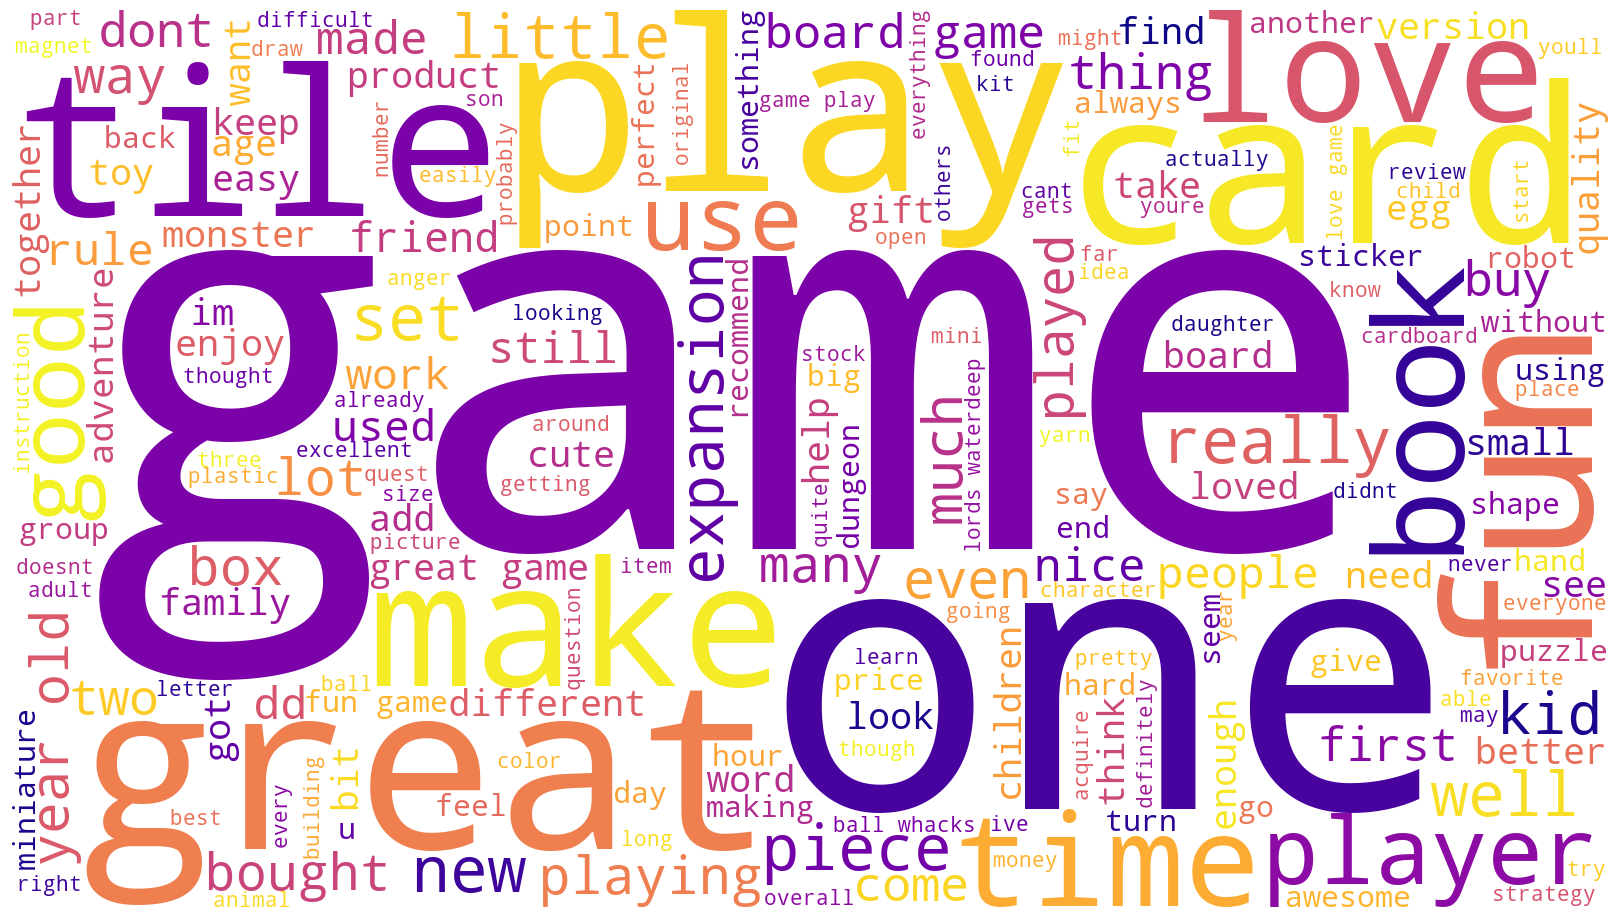

In [12]:
# Create a wordcloud without stop words as an initial visualization

wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(tokens_r_string) 

# Plot the wordcloud image

plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()


**The wordcloud shows the most often used words within our review column.**

In [13]:
# Digging deeper into the most often used words
# Displaying the 15 most common words within a dataframe

counts_r = pd.DataFrame(Counter(tokens_r).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

# Preview data.
counts_r

,Frequency
Word,
game,1681
great,589
fun,553
one,530
play,502
like,414
love,324
really,319
get,319


**Although 'great', 'fun', 'like', 'love', 'good' are indicating a positive sentiment,<br>
we should conduct further analysis to extract appropriate insights.**

In [14]:
# Next up, stopword removal must be conducted also for the review column

from textblob import Word

# Function to remove stopwords from a given text using TextBlob

def remove_stopwords(text):
    blob = TextBlob(text)
    words = blob.words
    words = [Word(word).lemmatize() for word in words if word.lower() not in english_stopwords]
    return ' '.join(words)

# Apply the remove_stopwords function to the 'review' column

df['review'] = df['review'].apply(remove_stopwords)

# Preview the data

df

,gender,age,remuneration,spending_score,loyalty_points,education,product,review,token_r
0,Male,18,12.30,39,210,graduate,453,come dm screen space screen absolute premium f...,"[when, it, comes, to, a, dms, screen, the, spa..."
1,Male,23,12.30,81,524,graduate,466,open letter galeforce9 unpainted miniature bad...,"[an, open, letter, to, galeforce9, your, unpai..."
2,Female,22,13.12,6,40,graduate,254,nice art nice printing two panel filled genera...,"[nice, art, nice, printing, why, two, panels, ..."
3,Female,25,13.12,77,562,graduate,263,amazing buy bought gift new dm perfect,"[amazing, buy, bought, it, as, a, gift, for, o..."
4,Female,33,13.94,40,366,graduate,291,review gf9s previous screen completely unneces...,"[as, my, review, of, gf9s, previous, screens, ..."
...,...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,perfect word game mixed age mom perhaps giving...,"[the, perfect, word, game, for, mixed, ages, w..."
1976,Female,43,92.66,8,539,PhD,979,great game think would like first received tur...,"[great, game, did, not, think, i, would, like,..."
1977,Male,34,92.66,91,5614,graduate,1012,great game keep mind nimble,"[great, game, for, all, keeps, the, mind, nimble]"
1978,Male,34,98.40,16,1048,PhD,1031,fun game,"[fun, game]"


In [15]:
# Determine polarity/sentiment of the review column using textblob

def generate_polarity(comment):
    '''Extract polarity score (-1 to +1) for each comment'''
    return TextBlob(comment).sentiment[0]

# Using a new column with the polarity scores 

df['sentiment_r'] = df['review'].apply(generate_polarity)

# Preview the result

df

,gender,age,remuneration,spending_score,loyalty_points,education,product,review,token_r,sentiment_r
0,Male,18,12.30,39,210,graduate,453,come dm screen space screen absolute premium f...,"[when, it, comes, to, a, dms, screen, the, spa...",-0.242857
1,Male,23,12.30,81,524,graduate,466,open letter galeforce9 unpainted miniature bad...,"[an, open, letter, to, galeforce9, your, unpai...",-0.040608
2,Female,22,13.12,6,40,graduate,254,nice art nice printing two panel filled genera...,"[nice, art, nice, printing, why, two, panels, ...",0.125457
3,Female,25,13.12,77,562,graduate,263,amazing buy bought gift new dm perfect,"[amazing, buy, bought, it, as, a, gift, for, o...",0.578788
4,Female,33,13.94,40,366,graduate,291,review gf9s previous screen completely unneces...,"[as, my, review, of, gf9s, previous, screens, ...",-0.316667
...,...,...,...,...,...,...,...,...,...,...
1975,Female,37,84.46,69,4031,PhD,977,perfect word game mixed age mom perhaps giving...,"[the, perfect, word, game, for, mixed, ages, w...",0.168750
1976,Female,43,92.66,8,539,PhD,979,great game think would like first received tur...,"[great, game, did, not, think, i, would, like,...",0.158333
1977,Male,34,92.66,91,5614,graduate,1012,great game keep mind nimble,"[great, game, for, all, keeps, the, mind, nimble]",0.200000
1978,Male,34,98.40,16,1048,PhD,1031,fun game,"[fun, game]",-0.050000


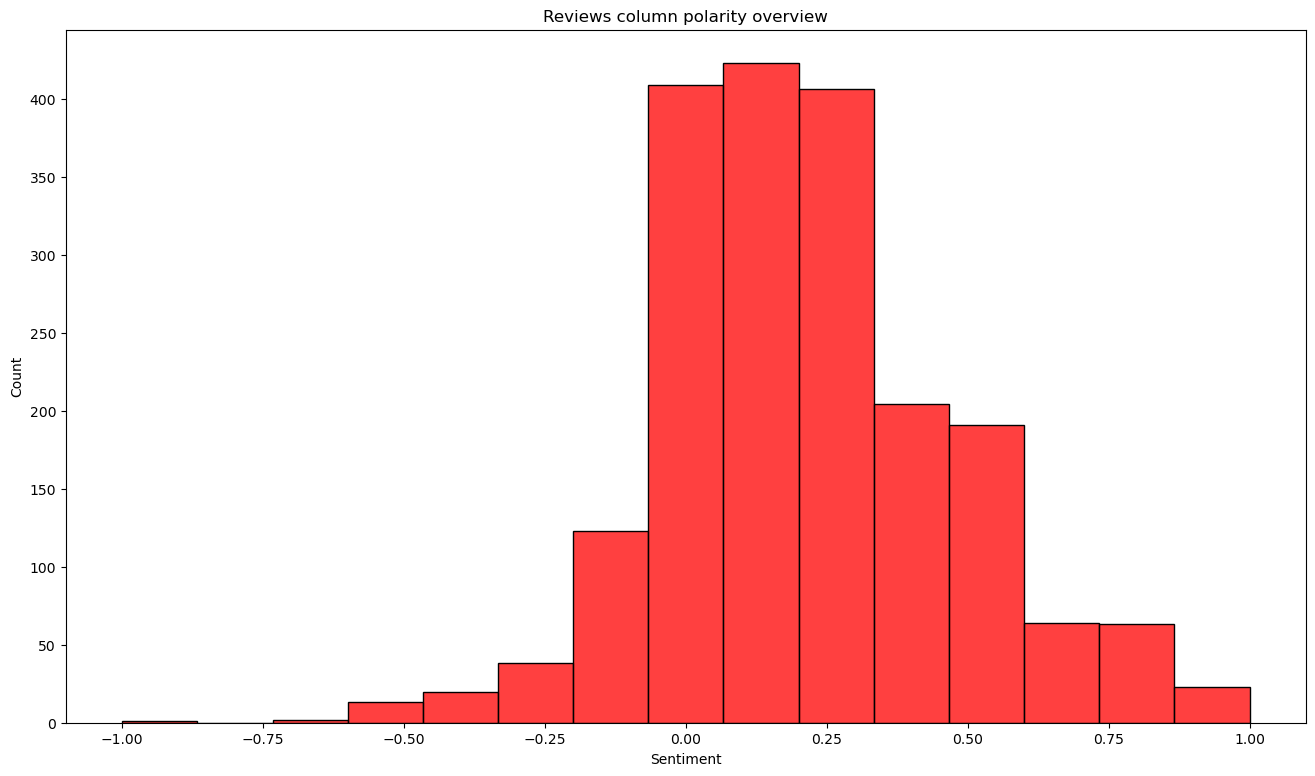

In [16]:
# Visualizing sentiment distribution of review column

plt.figure(figsize=(16,9))

sns.histplot(data=df['sentiment_r'], bins=15, color='red')

# Adjusting labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Reviews column polarity overview')

# Displaying the plot
plt.show()


In [17]:
# Review: Examining polarity scores

df['sentiment_r'].describe()


count    1980.000000
mean        0.209914
std         0.263265
min        -1.000000
25%         0.033333
50%         0.177436
75%         0.360483
max         1.000000
Name: sentiment_r, dtype: float64

**We notice a slight positive sentiment (-1 = bad, 1 = positive) and a kind of normal-distributed looking<br>
histogram. Next up, we could visualize which of our products are the ones with the worst and the best<br>
afiliated customer reviews.**

In [18]:
# How many products do we have? 

df['product'].nunique()

200

**There are 200 different products in our product column.**

In [19]:
# Filtering the top 10 and the flop 10 products:

# Step 1: Calculate the mean sentiment_r value and count for each unique product

product_sentiment_summary = df.groupby('product')['sentiment_r'].agg(['mean', 'count'])

# Step 2: Sort the grouped DataFrame by mean sentiment_r values in descending order

sorted_products = product_sentiment_summary.sort_values(by='mean', ascending=False)

# Step 3: Extract the top 10 and flop 10 products

top_10_products = sorted_products.head(10).reset_index()
flop_10_products = sorted_products.tail(10).reset_index()

print("Top 10 products:")
print(top_10_products)
print("\nFlop 10 products:")
print(flop_10_products)


Top 10 products:
   product      mean  count
0     9119  0.453042     10
1     9080  0.425636     10
2     4619  0.400219     10
3    10995  0.396548     10
4     4065  0.391822     10
5     1183  0.383735      8
6    11004  0.383547     10
7     8962  0.381179     10
8     6646  0.351498     10
9      629  0.349045     10

Flop 10 products:
   product      mean  count
0     5512  0.063679     10
1      231  0.063384     10
2      876  0.059493     10
3     3436  0.034275     10
4     6431  0.028748      9
5     2849  0.023214      9
6     4399  0.013790     10
7     2795  0.001294     10
8     1459 -0.008178      8
9     9597 -0.016287     10


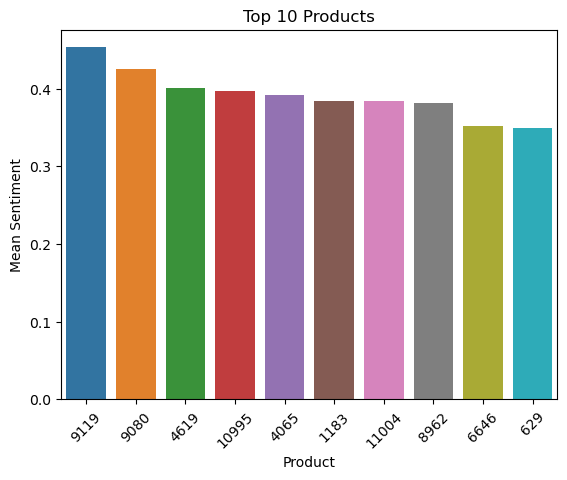

In [20]:
# Visualizing the findings for TOP10

sns.barplot(data=top_10_products, x='product', y='mean', order=top_10_products['product'])
plt.xlabel('Product')
plt.ylabel('Mean Sentiment')
plt.title('Top 10 Products')
plt.xticks(rotation=45)
plt.show()

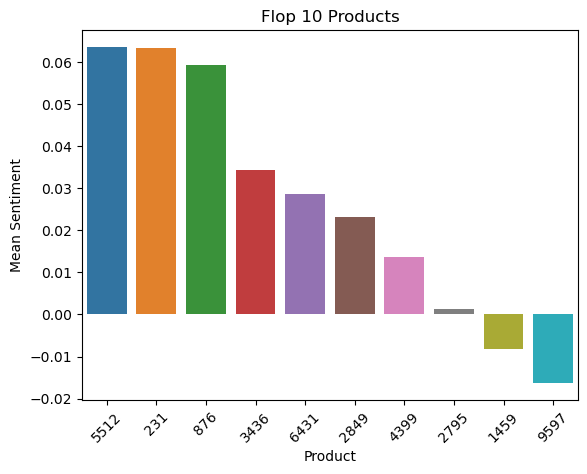

In [21]:
# Visualizing the findings for the FLOP10

sns.barplot(data=flop_10_products, x='product', y='mean', order=flop_10_products['product'])
plt.xlabel('Product')
plt.ylabel('Mean Sentiment')
plt.title('Flop 10 Products')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='mean', ylabel='Count'>

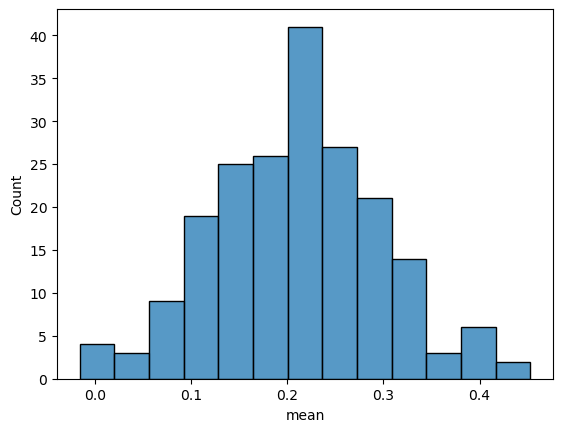

In [22]:
# Lets investigate the distribution of mean reviews

sns.histplot(data=product_sentiment_summary['mean'])


**Means are in a standard-shaped distribution, but we are able to identify,<br>
that some of the products received high ratings, while others don't. These<br>
products should be investigated. As we've identified the Top10 and Flop10<br>
based on sentiment, we continue to dig deeper into sentiments.**

In [23]:
# What are the reviews with the highest and lowest sentiments? 
# Can we extract any value?

# Top 20 positive reviews.
# Creating a dataframe for positive review comments

positive_reviews = df.nlargest(20, 'sentiment_r')

# Use only necessary columns and use some formatting

positive_reviews = positive_reviews[['review', 'sentiment_r']]
positive_reviews.style.set_properties(subset=['review'], **{'width': '1200px'})

# View output

positive_reviews


,review,sentiment_r
7,came perfect condition,1.000
165,awesome book,1.000
194,awesome gift,1.000
492,excellent activity teaching selfmanagement skill,1.000
520,perfect ordered,1.000
587,wonderful product,1.000
605,delightful product,1.000
617,wonderful grandson learn resurrection story,1.000
786,perfect,1.000
928,awesome,1.000


In [24]:
# Top 20 negative reviews.
# Creating a dataframe for positive review comments

negative_reviews = df.nsmallest(20, 'sentiment_r')

# Use only necessary columns and use some formatting

negative_reviews = negative_reviews[['review', 'sentiment_r']]
pd.set_option('display.max_colwidth', None)

# View output

negative_reviews


,review,sentiment_r
208,booo unles patient know measure didnt patience neither daughter boring unless craft person,-1.000000
522,keep client engaged helping develop anger management skill criticism wish card question,-0.700000
174,sent product granddaughter pompom maker come two part supposed snap together create pompoms however part making unusable cant make pompoms kit useless since sent gift return disappointed,-0.625000
182,incomplete kit disappointing,-0.600000
534,purchased recommendation two therapist working adopted child child found boring put half way,-0.583333
1784,im sorry find product boring frank juvenile,-0.583333
363,one staff using game soon dont know well work yet looking card believe helpful getting conversation started regarding anger control,-0.550000
117,bought christmas gift grandson sticker book go wrong gift,-0.500000
173,horrible nothing say would give zero star possible,-0.500000
227,gift daughter found difficult use,-0.500000


**No wrongly identified reviews can be found. The output seems reliable from these samples.**

In [25]:
# Check correlations between numerical columns to identify potential relationships

df.corr()

,age,remuneration,spending_score,loyalty_points,product,sentiment_r
age,1.000000,-0.006373,-0.220264,-0.039533,0.005340,-0.018577
remuneration,-0.006373,1.000000,0.007778,0.617328,0.305723,0.018774
spending_score,-0.220264,0.007778,1.000000,0.672927,-0.004683,0.023499
loyalty_points,-0.039533,0.617328,0.672927,1.000000,0.181523,0.016765
product,0.005340,0.305723,-0.004683,0.181523,1.000000,0.054581
sentiment_r,-0.018577,0.018774,0.023499,0.016765,0.054581,1.000000


**Looking at sentiment_r correlations, we cannot see any significant values. It could<br>
be the case, that gender or education describe sentiment better. Let's investigate.**

In [26]:
# Investigating values contained in education and gender

print(df['gender'].unique())
print(df['education'].unique())


['Male' 'Female']
['graduate' 'PhD' 'diploma' 'postgraduate' 'Basic']


In [27]:
# Replacing genders with numerical values
# male = 0, female = 1

df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})

# Replacing degrees with numerical values from lowest to highest

df['education'] = df['education'].replace({
    'Basic': 0,
    'diploma': 1,
    'graduate': 2,
    'postgraduate': 3,
    'PhD': 4
})

df

,gender,age,remuneration,spending_score,loyalty_points,education,product,review,token_r,sentiment_r
0,0,18,12.30,39,210,2,453,come dm screen space screen absolute premium fact 50 space wasted art terribly informative needed art well make completely useless reason gave 2 star 1 technically speaking least still stand block note dice roll drop ball completely,"[when, it, comes, to, a, dms, screen, the, space, on, the, screen, itself, is, at, an, absolute, premium, the, fact, that, 50, of, this, space, is, wasted, on, art, and, not, terribly, informative, or, needed, art, as, well, makes, it, completely, useless, the, only, reason, that, i, gave, it, 2, stars, and, not, 1, was, that, technically, speaking, it, can, at, least, still, stand, up, to, block, your, notes, and, dice, rolls, other, than, that, it, drops, the, ball, completely]",-0.242857
1,0,23,12.30,81,524,2,466,open letter galeforce9 unpainted miniature bad spell card great board game meh dm screen however freaking terrible im still waiting single screen isnt polluted pointless artwork useful referenceable table youve created single use screen useful running storm king thunder adventure even despite fact geared adventure path usefulness negligible best massive swath inner panel wasted artwork bloated overland map could easily reduced single panel size table nighuseless short stop making crap dm screen,"[an, open, letter, to, galeforce9, your, unpainted, miniatures, are, very, not, bad, your, spell, cards, are, great, your, board, games, are, meh, your, dm, screens, however, are, freaking, terrible, im, still, waiting, for, a, single, screen, that, isnt, polluted, with, pointless, artwork, where, useful, referenceable, tables, should, be, once, again, youve, created, a, single, use, screen, that, is, only, useful, when, running, the, storm, kings, thunder, adventure, even, despite, the, fact, that, its, geared, to, that, adventure, path, its, usefulness, negligible, at, best, i, massive, swath, of, the, inner, panel, is, wasted, on, artwork, and, a, bloated, overland, map, which, ...]",-0.040608
2,1,22,13.12,6,40,2,254,nice art nice printing two panel filled general forgotten realm map beyond one blue ocean waste dont understand cant make dm screen useful kind adventure rather solely specific adventure youre supposed able transpose adventure land outside forgotten realm even list new monster npc would least useful map even would stuff related running game broaduse stuff related giant thing curse strahd make useful raven loft undead horror campaign general instead huge amount screen space solely mapping castle ravenloft useful small fraction time even curse strahd adventure let alone various ravenloft adventuring really kill extended use screen thinking potential use adventure question well use broader sense rage demon screen far useful broad dark adventuring covering lot rule various condition may suffer map one panel storm giant one decent table includes really miss mark maybe ask dm would use,"[nice, art, nice, printing, why, two, panels, are, filled, with, a, general, forgotten, realms, map, is, beyond, me, most, of, one, of, them, is, all, blue, ocean, such, a, waste, i, dont, understand, why, they, cant, make, these, dm, screens, more, useful, for, these, kinds, of, adventures, rather, than, solely, the, specific, adventure, youre, supposed, to, be, able, to, transpose, this, adventure, to, other, lands, outside, the, forgotten, realms, so, even, just, a, list, of, new, monsters, or, npcs, would, at, least, be, useful, than, the, map, even, more, would, just, be, stuff, related, to, running, the, game, but, broaduse, ...]",0.125457
3,1,25,13.12,77,562,2,263,amazing buy bought gift new dm perfect,"[amazing, buy, bought, it, as, a, gift, for, our, new, dm, and, its, perfect]",0.578788
4,1,33,13.94,40,366,2,291,review gf9s previous screen completely unnecessary nearly useless skip definition waste money,"[as, my, review, of, gf9s, previous, screens, these, were, compl

In [28]:
# Check correlations again and see if gender and education show a 
# relationship to the sentiment

df.corr()

,gender,age,remuneration,spending_score,loyalty_points,education,product,sentiment_r
gender,1.000000,-0.063016,-0.037342,0.031071,0.021898,-0.047367,-0.012855,0.020855
age,-0.063016,1.000000,-0.006373,-0.220264,-0.039533,-0.029767,0.005340,-0.018577
remuneration,-0.037342,-0.006373,1.000000,0.007778,0.617328,0.046524,0.305723,0.018774
spending_score,0.031071,-0.220264,0.007778,1.000000,0.672927,-0.024075,-0.004683,0.023499
loyalty_points,0.021898,-0.039533,0.617328,0.672927,1.000000,-0.045103,0.181523,0.016765
education,-0.047367,-0.029767,0.046524,-0.024075,-0.045103,1.000000,-0.046688,0.002782
product,-0.012855,0.005340,0.305723,-0.004683,0.181523,-0.046688,1.000000,0.054581
sentiment_r,0.020855,-0.018577,0.018774,0.023499,0.016765,0.002782,0.054581,1.000000


**As all correlations between sentiment_r and other columns are not greater than 0.025, we can assume<br>
that none of the variables describes sentiment_r in a significant way. Therefore, we do not perform a<br>
regression analysis for the variables.**